# Getting Started with torchvine

**torchvine** is a pure-PyTorch vine copula library — GPU-ready, differentiable, and fully API-compatible with [pyvinecopulib](https://github.com/vinecopulib/pyvinecopulib).

This notebook covers:
1. Imports and setup
2. Creating bivariate copulas
3. Evaluating PDF, CDF, and h-functions
4. Simulating from copulas
5. Fitting copulas to data
6. Building vine copulas

In [1]:
import torch
import torchvine as tv
import matplotlib.pyplot as plt

print(f'torchvine {tv.__version__}')
print(f'PyTorch {torch.__version__}')

torchvine 0.1.0
PyTorch 2.10.0+cpu


## 1. Creating a Bivariate Copula

Create a Gaussian copula with correlation parameter ρ = 0.7:

In [2]:
cop = tv.Bicop(tv.BicopFamily.gaussian, parameters=torch.tensor([0.7]))
print(cop.str())
print(f'Kendall tau: {cop.parameters_to_tau():.4f}')

<torchvine.Bicop>
  family: gaussian
  parameters: [0.7000]
  var_types: ['c', 'c']
Kendall tau: 0.4936


## 2. Evaluating PDF and CDF

Evaluate the copula density on uniform data:

In [3]:
u = torch.rand(1000, 2, dtype=torch.float64)
pdf_vals = cop.pdf(u)
logpdf = cop.loglik(u)
print(f'PDF shape: {pdf_vals.shape}')
print(f'Mean PDF: {pdf_vals.mean():.4f}')
print(f'Log-likelihood: {logpdf:.2f}')

PDF shape: torch.Size([1000])
Mean PDF: 1.0046
Log-likelihood: -679.53


## 3. h-functions (Conditional Distribution)

h-functions are the core building block of vine copulas:

In [4]:
h1 = cop.hfunc1(u)  # F(u1 | u2)
h2 = cop.hfunc2(u)  # F(u2 | u1)
print(f'hfunc1 range: [{h1.min():.4f}, {h1.max():.4f}]')
print(f'hfunc2 range: [{h2.min():.4f}, {h2.max():.4f}]')

hfunc1 range: [0.0000, 1.0000]
hfunc2 range: [0.0000, 1.0000]


## 4. Simulation

Samples shape: torch.Size([2000, 2])


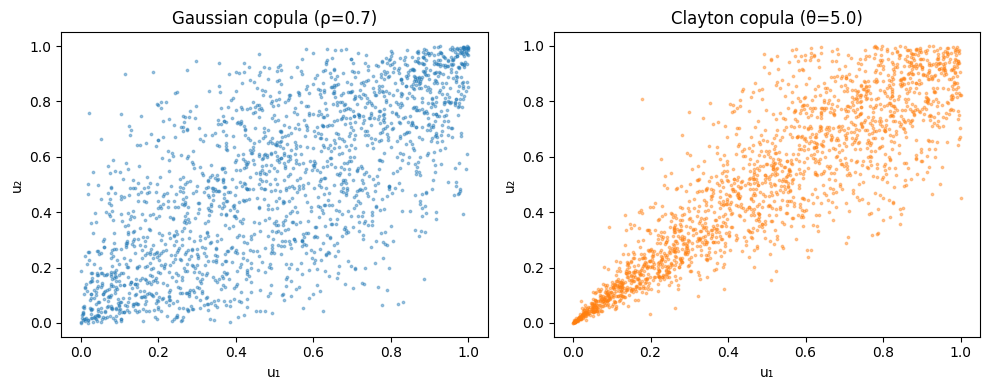

In [5]:
samples = cop.simulate(2000)
print(f'Samples shape: {samples.shape}')

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(samples[:, 0].numpy(), samples[:, 1].numpy(), s=3, alpha=0.4)
axes[0].set_title('Gaussian copula (ρ=0.7)')
axes[0].set_xlabel('u₁'); axes[0].set_ylabel('u₂')

# Compare with Clayton
clay = tv.Bicop(tv.BicopFamily.clayton, parameters=torch.tensor([5.0]))
s2 = clay.simulate(2000)
axes[1].scatter(s2[:, 0].numpy(), s2[:, 1].numpy(), s=3, alpha=0.4, color='C1')
axes[1].set_title('Clayton copula (θ=5.0)')
axes[1].set_xlabel('u₁'); axes[1].set_ylabel('u₂')
plt.tight_layout()
plt.show()

## 5. Fitting a Copula to Data

Use `select()` for automatic family and parameter selection:

In [6]:
# Generate data from a known copula
true_cop = tv.Bicop(tv.BicopFamily.frank, parameters=torch.tensor([8.0]))
data = true_cop.simulate(1000)

# Fit — automatically selects best family
fitted = tv.Bicop()
fitted.select(data)
print(fitted.str())
print(f'True tau:  {true_cop.parameters_to_tau():.4f}')
print(f'Fitted tau: {fitted.parameters_to_tau():.4f}')

<torchvine.Bicop>
  family: frank
  parameters: [8.2661]
  var_types: ['c', 'c']
  nobs: 1000
True tau:  0.6026
Fitted tau: 0.6123


E:\Agentic_AI\torchvine\torchvine\interpolation.py:101: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen/native/BucketizationUtils.h:34.)
  i = torch.searchsorted(grid, x0, right=True) - 1


In [7]:
# Constrain to specific family
fitted2 = tv.Bicop()
fitted2.select(data, controls=tv.FitControlsBicop(family_set=[tv.BicopFamily.frank]))
print(fitted2.str())

<torchvine.Bicop>
  family: frank
  parameters: [8.2661]
  var_types: ['c', 'c']
  nobs: 1000


## 6. Vine Copula (Quick Start)

Fit a vine copula to multivariate data:

In [8]:
torch.manual_seed(42)
data5 = torch.rand(500, 4, dtype=torch.float64)

vine = tv.Vinecop.from_dimension(4)
vine.select(data5)
print(vine.str())
print(f'\nLog-likelihood: {vine.loglik(data5):.2f}')
print(f'AIC: {vine.aic(data5):.2f}')

<torchvine.Vinecop> Vinecop model with 4 variables
tree  edge   conditioned variables   conditioning variables   var_types      family  rotation            parameters       tau
   0     0                                                   ['c', 'c']       indep         0                            0.00
   0     1                                                   ['c', 'c']       indep         0                            0.00
   0     2                                                   ['c', 'c']       indep         0                            0.00
   1     0                                                   ['c', 'c']       indep         0                            0.00
   1     1                                                   ['c', 'c']       indep         0                            0.00
   2     0                                                   ['c', 'c']       indep         0                            0.00

Log-likelihood: 0.00
AIC: 0.00


In [9]:
# Simulate from the fitted vine
sim = vine.simulate(500)
print(f'Simulated shape: {sim.shape}')

Simulated shape: torch.Size([500, 4])


---

**Next:** See [02_bivariate_copulas.ipynb](02_bivariate_copulas.ipynb) for an in-depth tour of all copula families.